In [1]:
!pip install torchinfo

# IMPORT LIBRARIES

In [2]:
import time
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import numpy as np
import cv2
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
from torchinfo import summary
import torchvision.models as models
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import OrderedDict
import platform
import psutil
import random
import glob
from tqdm import tqdm
from PIL import Image
from torchvision import transforms
from torchvision.transforms import ColorJitter, RandomRotation, RandomResizedCrop
from torchvision.transforms.functional import gaussian_blur
from PIL import ImageOps
from tabulate import tabulate

# CONFIGURATION

In [3]:
cpu_info = platform.processor()

ram_info = psutil.virtual_memory()
total_ram_gb = ram_info.total / (1024 ** 3)

try:
    gpu_info = !nvidia-smi --query-gpu=gpu_name --format=csv
    gpu_name = gpu_info[1]
except:
    gpu_name = "No GPU available"

print("CPU:", cpu_info)
print("Total RAM (GB):", round(total_ram_gb, 2))
print("GPU:", gpu_name)

CPU: x86_64
Total RAM (GB): 31.35
GPU: Tesla P100-PCIE-16GB


# SEED VALUE

In [4]:
seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# DATA LOADING

In [5]:
data_dir = "/kaggle/input/fish-ra"

file_paths = []
labels = []

for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    for image_name in os.listdir(class_dir):
        file_paths.append(os.path.join(class_dir, image_name))
        labels.append(class_name)

df = pd.DataFrame({"file_path": file_paths, "label": labels})
df = df.sample(frac=1).reset_index(drop=True)

Class: Tarabaim, Count: 2500
Class: Shol, Count: 2500
Class: Puti, Count: 2500
Class: DeshiPuti, Count: 2500
Class: Aair, Count: 2500
Class: Tengra, Count: 2500
Class: Pabda, Count: 2500
Class: Foli, Count: 2500
Class: Katla, Count: 2500
Class: Ilish, Count: 2500
Class: Taki, Count: 2500
Class: KalBaush, Count: 2500
Class: Chapila, Count: 2500
Class: Magur, Count: 2500
Class: Pangas, Count: 2500
Class: Mrigel, Count: 2500
Class: Telapiya, Count: 2500
Class: Koi, Count: 2500
Class: Boal, Count: 2500
Class: Rui, Count: 2500


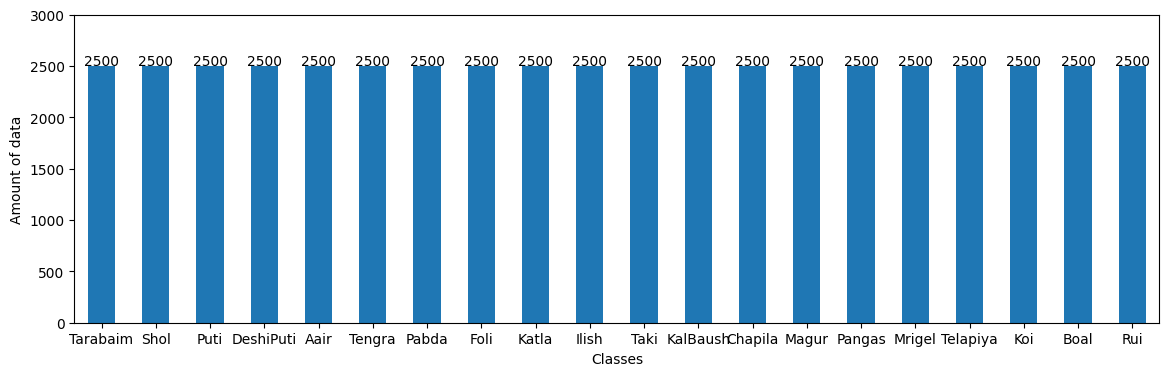

In [6]:
class_counts_train = df['label'].value_counts()

for class_name, count in class_counts_train.items():
    print(f"Class: {class_name}, Count: {count}")

plt.figure(figsize=(14, 4))
ax = class_counts_train.plot(kind='bar')
plt.xlabel('Classes')
plt.ylabel('Amount of data')
plt.xticks(rotation=360)
for i, count in enumerate(class_counts_train):
    ax.text(i, count + 5, str(count), ha='center')
plt.ylim(0, max(class_counts_train) * 1.2)
plt.show()

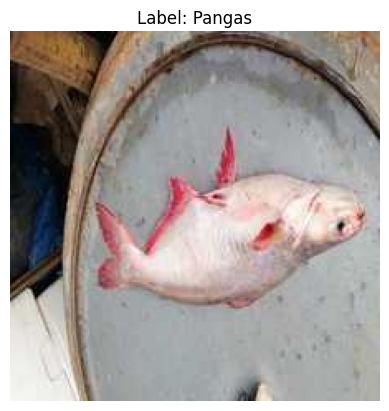

In [7]:
random_index = random.randint(1, len(df) - 1)
random_row = df.iloc[random_index]

file_path = random_row['file_path']
label = random_row['label']

image = Image.open(file_path)
plt.imshow(image)
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

# TRAINING-TESTING-VALIDATION(RATIO 70-15-15)

In [8]:
train_dataframe, temp_dataframe = train_test_split(df, test_size=0.30, 
                                     stratify=df['label'], random_state=42)
valid_dataframe, test_df = train_test_split(temp_dataframe, test_size=0.50, 
                                            stratify=temp_dataframe['label'], random_state=42)

In [9]:
print("Training Data: ", len(train_dataframe))
print("Validation Data: ", len(valid_dataframe))
print("Test Data: ", len(test_df))
print("-------------------------------------------")
print("Total amounts of data in the dataset: ", len(df))

Training Data:  35000
Validation Data:  7500
Test Data:  7500
-------------------------------------------
Total amounts of data in the dataset:  50000


# DEVICE

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# CHECKPOINT

In [11]:
save_path_checkpoints = "/kaggle/working/"
os.makedirs(save_path_checkpoints, exist_ok=True)

# DATASET CLASS, DATALOADER, TRANSFORM

In [12]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, normalize, is_lb=False):
        self.dataframe = dataframe
        self.normalize = normalize
        self.is_lb = is_lb
        class_names = sorted(self.dataframe['label'].unique())  # Ensure consistent order
        self.label_map = {class_name: idx for idx, class_name in enumerate(class_names)}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_path = self.dataframe.iloc[index]['file_path']
        image = PIL.Image.open(img_path)

        if self.is_lb:
            label = self.label_map[self.dataframe.iloc[index]['label']]
            return self.normalize(image), label
        else:
            return self.normalize(image), self.normalize(image)

In [13]:
normalize = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataset = ImageDataset(train_dataframe, normalize, is_lb=True)
print(train_dataset.label_map)

{'Aair': 0, 'Boal': 1, 'Chapila': 2, 'DeshiPuti': 3, 'Foli': 4, 'Ilish': 5, 'KalBaush': 6, 'Katla': 7, 'Koi': 8, 'Magur': 9, 'Mrigel': 10, 'Pabda': 11, 'Pangas': 12, 'Puti': 13, 'Rui': 14, 'Shol': 15, 'Taki': 16, 'Tarabaim': 17, 'Telapiya': 18, 'Tengra': 19}


In [14]:
train_batch = 32
val_batch = 8

def data_transfrom():
    normalize = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
            ])

    train_dataset = ImageDataset (
        train_dataframe,
        normalize,
        is_lb=True
    )

    valid_dataset = ImageDataset(
        valid_dataframe,
        normalize,
        is_lb=True
    )

    test_dataset = ImageDataset(
        test_df,
        normalize,
        is_lb=True
    )

    dataloader_train_dataset = DataLoader(train_dataset, batch_size = train_batch, shuffle=True, num_workers=2)
    dataloader_valid_dataset = DataLoader(valid_dataset, batch_size = val_batch, shuffle=False, num_workers=2)
    dataloader_test_dataset = DataLoader(test_dataset, batch_size = val_batch, shuffle=False, num_workers=2)

    return dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset

dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset = data_transfrom()

# VGG19

In [15]:
total_class = 20     
learning_rate = 0.0001


model = models.vgg19(pretrained=True)


for param in model.features.parameters():
    param.requires_grad = False


model.classifier[6] = nn.Linear(model.classifier[6].in_features, total_class)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


optimizer = optim.Adam(model.classifier.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()




/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 198MB/s]


In [16]:
summary(model, input_size=(train_batch, 3, 224, 224)) 

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [32, 20]                  --
├─Sequential: 1-1                        [32, 512, 7, 7]           --
│    └─Conv2d: 2-1                       [32, 64, 224, 224]        (1,792)
│    └─ReLU: 2-2                         [32, 64, 224, 224]        --
│    └─Conv2d: 2-3                       [32, 64, 224, 224]        (36,928)
│    └─ReLU: 2-4                         [32, 64, 224, 224]        --
│    └─MaxPool2d: 2-5                    [32, 64, 112, 112]        --
│    └─Conv2d: 2-6                       [32, 128, 112, 112]       (73,856)
│    └─ReLU: 2-7                         [32, 128, 112, 112]       --
│    └─Conv2d: 2-8                       [32, 128, 112, 112]       (147,584)
│    └─ReLU: 2-9                         [32, 128, 112, 112]       --
│    └─MaxPool2d: 2-10                   [32, 128, 56, 56]         --
│    └─Conv2d: 2-11                      [32, 256, 56, 56]   

# TRAINING

In [17]:
start_time = time.time()

def train_model(model, criterion, optimizer, dataloader_train_dataset, dataloader_valid_dataset, num_epochs=100, save_path_checkpoints="checkpoints"):
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    best_val_acc = 0.0

    for epoch in range(num_epochs):
        
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        progress_bar = tqdm(enumerate(dataloader_train_dataset), total=len(dataloader_train_dataset))
        for i, (inputs, labels) in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            progress_bar.set_description(f"Epoch {epoch+1}/{num_epochs}")
            progress_bar.set_postfix(loss=running_loss / total_train, acc=correct_train / total_train)

        epoch_train_loss = running_loss / total_train
        epoch_train_acc = correct_train / total_train
        train_loss_history.append(epoch_train_loss)
        train_acc_history.append(epoch_train_acc)

        print('Training Loss: {:.3f} Acc: {:.3f}'.format(epoch_train_loss, epoch_train_acc))

        
        model.eval()
        running_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in dataloader_valid_dataset:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = running_loss / total_val
        epoch_val_acc = correct_val / total_val
        val_loss_history.append(epoch_val_loss)
        val_acc_history.append(epoch_val_acc)

        print('Validation Loss: {:.3f} Acc: {:.3f}'.format(epoch_val_loss, epoch_val_acc))

        
    
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_epoch = epoch + 1
            filepath = f"{save_path_checkpoints}/model.pt"
            checkpoint = {
                "epoch": epoch + 1,
                "model_weight": model.state_dict(),
                "optimizer_state": optimizer.state_dict()
            }
            torch.save(checkpoint, filepath)
            print(f"Best model saved at epoch {best_epoch} with validation accuracy: {best_val_acc:.3f}")

    return train_loss_history, train_acc_history, val_loss_history, val_acc_history


train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(
    model, criterion, optimizer, dataloader_train_dataset, dataloader_valid_dataset, save_path_checkpoints=save_path_checkpoints
)

end_time = time.time()
training_time = end_time - start_time
print(f"Training Time: {training_time:.2f} seconds ---> {training_time/60:.2f} minutes")

data = {
    'Epoch': list(range(1, len(train_loss_history) + 1)),
    'Train Loss': train_loss_history,
    'Train Accuracy': train_acc_history,
    'Validation Loss': val_loss_history,
    'Validation Accuracy': val_acc_history
}

history = pd.DataFrame(data)
history.to_excel('/kaggle/working/training_data.xlsx', index=False)


Epoch 1/100: 100%|██████████| 1094/1094 [02:16<00:00,  8.00it/s, acc=0.895, loss=0.338]

Training Loss: 0.338 Acc: 0.895


Validation Loss: 0.095 Acc: 0.968
Best model saved at epoch 1 with validation accuracy: 0.968


Epoch 2/100: 100%|██████████| 1094/1094 [02:16<00:00,  8.01it/s, acc=0.979, loss=0.0636]

Training Loss: 0.064 Acc: 0.979


Validation Loss: 0.100 Acc: 0.969
Best model saved at epoch 2 with validation accuracy: 0.969


Epoch 3/100: 100%|██████████| 1094/1094 [02:16<00:00,  8.01it/s, acc=0.983, loss=0.05]

Training Loss: 0.050 Acc: 0.983


Validation Loss: 0.089 Acc: 0.973
Best model saved at epoch 3 with validation accuracy: 0.973


Epoch 4/100: 100%|██████████| 1094/1094 [02:16<00:00,  8.00it/s, acc=0.987, loss=0.0412]

Training Loss: 0.041 Acc: 0.987


Validation Loss: 0.116 Acc: 0.974
Best model saved at epoch 4 with validation accuracy: 0.974


Epoch 5/100: 100%|██████████| 1094/1094 [02:16<00:00,  8.00it/s, acc=0.988, loss=0.041]

Training Loss: 0.041 Acc: 0.988


Validation Loss: 0.084 Acc: 0.978
Best model saved at epoch 5 with validation accuracy: 0.978


Epoch 6/100: 100%|██████████| 1094/1094 [02:16<00:00,  8.01it/s, acc=0.991, loss=0.036]

Training Loss: 0.036 Acc: 0.991


Validation Loss: 0.075 Acc: 0.981
Best model saved at epoch 6 with validation accuracy: 0.981


Epoch 7/100: 100%|██████████| 1094/1094 [02:16<00:00,  8.01it/s, acc=0.989, loss=0.0411]

Training Loss: 0.041 Acc: 0.989


Validation Loss: 0.074 Acc: 0.982
Best model saved at epoch 7 with validation accuracy: 0.982


Epoch 8/100: 100%|██████████| 1094/1094 [02:16<00:00,  8.01it/s, acc=0.992, loss=0.0293]

Training Loss: 0.029 Acc: 0.992


Validation Loss: 0.098 Acc: 0.978


Epoch 9/100: 100%|██████████| 1094/1094 [02:16<00:00,  8.00it/s, acc=0.991, loss=0.0354]

Training Loss: 0.035 Acc: 0.991


Validation Loss: 0.109 Acc: 0.978


Epoch 10/100: 100%|██████████| 1094/1094 [02:16<00:00,  8.02it/s, acc=0.991, loss=0.0414]

Training Loss: 0.041 Acc: 0.991


Validation Loss: 0.122 Acc: 0.978


Epoch 11/100: 100%|██████████| 1094/1094 [02:16<00:00,  8.01it/s, acc=0.995, loss=0.0211]

Training Loss: 0.021 Acc: 0.995


Validation Loss: 0.104 Acc: 0.981


Epoch 12/100: 100%|██████████| 1094/1094 [02:16<00:00,  8.01it/s, acc=0.992, loss=0.0383]

Training Loss: 0.038 Acc: 0.992


Validation Loss: 0.092 Acc: 0.983
Best model saved at epoch 12 with validation accuracy: 0.983


Epoch 13/100: 100%|██████████| 1094/1094 [02:16<00:00,  8.00it/s, acc=0.993, loss=0.0335]

Training Loss: 0.033 Acc: 0.993


Validation Loss: 0.175 Acc: 0.975


Epoch 14/100: 100%|██████████| 1094/1094 [02:16<00:00,  8.01it/s, acc=0.995, loss=0.0268]

Training Loss: 0.027 Acc: 0.995


Validation Loss: 0.105 Acc: 0.985
Best model saved at epoch 14 with validation accuracy: 0.985


Epoch 15/100: 100%|██████████| 1094/1094 [02:16<00:00,  8.00it/s, acc=0.994, loss=0.0268]

Training Loss: 0.027 Acc: 0.994


Validation Loss: 0.115 Acc: 0.983


Epoch 16/100: 100%|██████████| 1094/1094 [02:16<00:00,  8.00it/s, acc=0.994, loss=0.0369]

Training Loss: 0.037 Acc: 0.994


Validation Loss: 0.149 Acc: 0.984


Epoch 17/100: 100%|██████████| 1094/1094 [02:16<00:00,  8.00it/s, acc=0.995, loss=0.031]

Training Loss: 0.031 Acc: 0.995


Validation Loss: 0.162 Acc: 0.982


Epoch 18/100: 100%|██████████| 1094/1094 [02:16<00:00,  8.00it/s, acc=0.996, loss=0.0222]

Training Loss: 0.022 Acc: 0.996


Validation Loss: 0.123 Acc: 0.985
Best model saved at epoch 18 with validation accuracy: 0.985


Epoch 19/100: 100%|██████████| 1094/1094 [02:16<00:00,  7.99it/s, acc=0.995, loss=0.0258]

Training Loss: 0.026 Acc: 0.995


Validation Loss: 0.157 Acc: 0.983


Epoch 20/100: 100%|██████████| 1094/1094 [02:16<00:00,  7.99it/s, acc=0.994, loss=0.0433]

Training Loss: 0.043 Acc: 0.994


Validation Loss: 0.163 Acc: 0.983


Epoch 21/100: 100%|██████████| 1094/1094 [02:16<00:00,  7.99it/s, acc=0.995, loss=0.0316]

Training Loss: 0.032 Acc: 0.995


Validation Loss: 0.156 Acc: 0.985


Epoch 22/100: 100%|██████████| 1094/1094 [02:16<00:00,  7.99it/s, acc=0.995, loss=0.0348]

Training Loss: 0.035 Acc: 0.995


Validation Loss: 0.133 Acc: 0.987
Best model saved at epoch 22 with validation accuracy: 0.987


Epoch 23/100: 100%|██████████| 1094/1094 [02:16<00:00,  8.00it/s, acc=0.996, loss=0.0277]

Training Loss: 0.028 Acc: 0.996


Validation Loss: 0.175 Acc: 0.985


Epoch 24/100: 100%|██████████| 1094/1094 [02:16<00:00,  8.00it/s, acc=0.996, loss=0.036]

Training Loss: 0.036 Acc: 0.996


Validation Loss: 0.224 Acc: 0.982


Epoch 25/100: 100%|██████████| 1094/1094 [02:16<00:00,  8.01it/s, acc=0.996, loss=0.0295]

Training Loss: 0.029 Acc: 0.996


Validation Loss: 0.204 Acc: 0.984


Epoch 26/100: 100%|██████████| 1094/1094 [02:16<00:00,  8.00it/s, acc=0.996, loss=0.0318]

Training Loss: 0.032 Acc: 0.996


Validation Loss: 0.271 Acc: 0.979


Epoch 27/100: 100%|██████████| 1094/1094 [02:16<00:00,  8.00it/s, acc=0.996, loss=0.0317]

Training Loss: 0.032 Acc: 0.996


Validation Loss: 0.204 Acc: 0.983


Epoch 28/100: 100%|██████████| 1094/1094 [02:16<00:00,  8.00it/s, acc=0.996, loss=0.0267]

Training Loss: 0.027 Acc: 0.996


Validation Loss: 0.190 Acc: 0.986


Epoch 29/100: 100%|██████████| 1094/1094 [02:16<00:00,  8.00it/s, acc=0.996, loss=0.0308]

Training Loss: 0.031 Acc: 0.996


Validation Loss: 0.154 Acc: 0.988
Best model saved at epoch 29 with validation accuracy: 0.988


Epoch 30/100: 100%|██████████| 1094/1094 [02:16<00:00,  8.00it/s, acc=0.997, loss=0.025]

Training Loss: 0.025 Acc: 0.997


Validation Loss: 0.233 Acc: 0.986


Epoch 31/100: 100%|██████████| 1094/1094 [02:16<00:00,  8.00it/s, acc=0.996, loss=0.0378]

Training Loss: 0.038 Acc: 0.996


Validation Loss: 0.254 Acc: 0.984


Epoch 32/100: 100%|██████████| 1094/1094 [02:16<00:00,  7.99it/s, acc=0.996, loss=0.0352]

Training Loss: 0.035 Acc: 0.996


Validation Loss: 0.213 Acc: 0.985


Epoch 33/100: 100%|██████████| 1094/1094 [02:16<00:00,  7.99it/s, acc=0.996, loss=0.0301]

Training Loss: 0.030 Acc: 0.996


Validation Loss: 0.234 Acc: 0.986


Epoch 34/100: 100%|██████████| 1094/1094 [02:16<00:00,  8.00it/s, acc=0.997, loss=0.0317]

Training Loss: 0.032 Acc: 0.997


Validation Loss: 0.228 Acc: 0.985


Epoch 35/100: 100%|██████████| 1094/1094 [02:16<00:00,  8.00it/s, acc=0.997, loss=0.0302]

Training Loss: 0.030 Acc: 0.997


Validation Loss: 0.228 Acc: 0.984


Epoch 36/100: 100%|██████████| 1094/1094 [02:17<00:00,  7.98it/s, acc=0.997, loss=0.0314]

Training Loss: 0.031 Acc: 0.997


Validation Loss: 0.202 Acc: 0.986


Epoch 37/100: 100%|██████████| 1094/1094 [02:16<00:00,  8.00it/s, acc=0.997, loss=0.0351]

Training Loss: 0.035 Acc: 0.997


Validation Loss: 0.229 Acc: 0.986


Epoch 38/100: 100%|██████████| 1094/1094 [02:16<00:00,  8.00it/s, acc=0.997, loss=0.0254]

Training Loss: 0.025 Acc: 0.997


Validation Loss: 0.201 Acc: 0.987


Epoch 39/100: 100%|██████████| 1094/1094 [02:16<00:00,  7.99it/s, acc=0.997, loss=0.0317]

Training Loss: 0.032 Acc: 0.997


Validation Loss: 0.214 Acc: 0.987


Epoch 40/100: 100%|██████████| 1094/1094 [02:17<00:00,  7.98it/s, acc=0.998, loss=0.0277]

Training Loss: 0.028 Acc: 0.998


Validation Loss: 0.176 Acc: 0.988
Best model saved at epoch 40 with validation accuracy: 0.988


Epoch 41/100: 100%|██████████| 1094/1094 [02:16<00:00,  8.00it/s, acc=0.997, loss=0.0321]

Training Loss: 0.032 Acc: 0.997


Validation Loss: 0.233 Acc: 0.986


Epoch 42/100: 100%|██████████| 1094/1094 [02:16<00:00,  7.99it/s, acc=0.997, loss=0.0326]

Training Loss: 0.033 Acc: 0.997


Validation Loss: 0.275 Acc: 0.986


Epoch 43/100: 100%|██████████| 1094/1094 [02:16<00:00,  7.99it/s, acc=0.997, loss=0.0389]

Training Loss: 0.039 Acc: 0.997


Validation Loss: 0.230 Acc: 0.987


Epoch 44/100: 100%|██████████| 1094/1094 [02:16<00:00,  7.99it/s, acc=0.998, loss=0.0185]

Training Loss: 0.019 Acc: 0.998


Validation Loss: 0.300 Acc: 0.986


Epoch 45/100: 100%|██████████| 1094/1094 [02:16<00:00,  8.00it/s, acc=0.997, loss=0.034]

Training Loss: 0.034 Acc: 0.997


Validation Loss: 0.265 Acc: 0.986


Epoch 46/100: 100%|██████████| 1094/1094 [02:16<00:00,  7.99it/s, acc=0.998, loss=0.0301]

Training Loss: 0.030 Acc: 0.998


Validation Loss: 0.270 Acc: 0.987


Epoch 47/100: 100%|██████████| 1094/1094 [02:16<00:00,  7.99it/s, acc=0.997, loss=0.0398]

Training Loss: 0.040 Acc: 0.997


Validation Loss: 0.267 Acc: 0.988


Epoch 48/100: 100%|██████████| 1094/1094 [02:16<00:00,  7.99it/s, acc=0.998, loss=0.0384]

Training Loss: 0.038 Acc: 0.998


Validation Loss: 0.266 Acc: 0.988


Epoch 49/100: 100%|██████████| 1094/1094 [02:16<00:00,  7.99it/s, acc=0.998, loss=0.0286]

Training Loss: 0.029 Acc: 0.998


Validation Loss: 0.306 Acc: 0.986


Epoch 50/100: 100%|██████████| 1094/1094 [02:17<00:00,  7.97it/s, acc=0.998, loss=0.0331]

Training Loss: 0.033 Acc: 0.998


Validation Loss: 0.432 Acc: 0.980


Epoch 51/100: 100%|██████████| 1094/1094 [02:16<00:00,  7.99it/s, acc=0.998, loss=0.0272]

Training Loss: 0.027 Acc: 0.998


Validation Loss: 0.299 Acc: 0.986


Epoch 52/100: 100%|██████████| 1094/1094 [02:16<00:00,  8.00it/s, acc=0.998, loss=0.0308]

Training Loss: 0.031 Acc: 0.998


Validation Loss: 0.294 Acc: 0.988


Epoch 53/100: 100%|██████████| 1094/1094 [02:17<00:00,  7.98it/s, acc=0.998, loss=0.0259]

Training Loss: 0.026 Acc: 0.998


Validation Loss: 0.242 Acc: 0.989
Best model saved at epoch 53 with validation accuracy: 0.989


Epoch 54/100: 100%|██████████| 1094/1094 [02:16<00:00,  7.99it/s, acc=0.997, loss=0.0353]

Training Loss: 0.035 Acc: 0.997


Validation Loss: 0.346 Acc: 0.986


Epoch 55/100: 100%|██████████| 1094/1094 [02:16<00:00,  7.99it/s, acc=0.998, loss=0.0216]

Training Loss: 0.022 Acc: 0.998


Validation Loss: 0.321 Acc: 0.986


Epoch 56/100: 100%|██████████| 1094/1094 [02:17<00:00,  7.98it/s, acc=0.998, loss=0.0252]

Training Loss: 0.025 Acc: 0.998


Validation Loss: 0.328 Acc: 0.985


Epoch 57/100: 100%|██████████| 1094/1094 [02:17<00:00,  7.98it/s, acc=0.999, loss=0.0179]

Training Loss: 0.018 Acc: 0.999


Validation Loss: 0.275 Acc: 0.988


Epoch 58/100: 100%|██████████| 1094/1094 [02:17<00:00,  7.97it/s, acc=0.998, loss=0.0398]

Training Loss: 0.040 Acc: 0.998


Validation Loss: 0.389 Acc: 0.984


Epoch 59/100: 100%|██████████| 1094/1094 [02:17<00:00,  7.97it/s, acc=0.997, loss=0.0415]

Training Loss: 0.042 Acc: 0.997


Validation Loss: 0.329 Acc: 0.988


Epoch 60/100: 100%|██████████| 1094/1094 [02:17<00:00,  7.97it/s, acc=0.998, loss=0.0341]

Training Loss: 0.034 Acc: 0.998


Validation Loss: 0.263 Acc: 0.988


Epoch 61/100: 100%|██████████| 1094/1094 [02:17<00:00,  7.97it/s, acc=0.998, loss=0.0265]

Training Loss: 0.027 Acc: 0.998


Validation Loss: 0.363 Acc: 0.986


Epoch 62/100: 100%|██████████| 1094/1094 [02:17<00:00,  7.98it/s, acc=0.998, loss=0.0253]

Training Loss: 0.025 Acc: 0.998


Validation Loss: 0.262 Acc: 0.988


Epoch 63/100: 100%|██████████| 1094/1094 [02:17<00:00,  7.98it/s, acc=0.998, loss=0.0238]

Training Loss: 0.024 Acc: 0.998


Validation Loss: 0.356 Acc: 0.987


Epoch 64/100: 100%|██████████| 1094/1094 [02:17<00:00,  7.97it/s, acc=0.998, loss=0.0336]

Training Loss: 0.034 Acc: 0.998


Validation Loss: 0.305 Acc: 0.985


Epoch 65/100: 100%|██████████| 1094/1094 [02:17<00:00,  7.98it/s, acc=0.997, loss=0.0477]

Training Loss: 0.048 Acc: 0.997


Validation Loss: 0.358 Acc: 0.987


Epoch 66/100: 100%|██████████| 1094/1094 [02:17<00:00,  7.97it/s, acc=0.999, loss=0.0209]

Training Loss: 0.021 Acc: 0.999


Validation Loss: 0.276 Acc: 0.991
Best model saved at epoch 66 with validation accuracy: 0.991


Epoch 67/100: 100%|██████████| 1094/1094 [02:17<00:00,  7.97it/s, acc=0.998, loss=0.0321]

Training Loss: 0.032 Acc: 0.998


Validation Loss: 0.301 Acc: 0.987


Epoch 68/100: 100%|██████████| 1094/1094 [02:17<00:00,  7.98it/s, acc=0.999, loss=0.0192]

Training Loss: 0.019 Acc: 0.999


Validation Loss: 0.311 Acc: 0.987


Epoch 69/100: 100%|██████████| 1094/1094 [02:17<00:00,  7.97it/s, acc=0.998, loss=0.0252]

Training Loss: 0.025 Acc: 0.998


Validation Loss: 0.265 Acc: 0.989


Epoch 70/100: 100%|██████████| 1094/1094 [02:17<00:00,  7.95it/s, acc=0.999, loss=0.0197]

Training Loss: 0.020 Acc: 0.999


Validation Loss: 0.324 Acc: 0.988


Epoch 71/100: 100%|██████████| 1094/1094 [02:17<00:00,  7.98it/s, acc=0.998, loss=0.0209]

Training Loss: 0.021 Acc: 0.998


Validation Loss: 0.361 Acc: 0.988


Epoch 72/100: 100%|██████████| 1094/1094 [02:16<00:00,  7.99it/s, acc=0.998, loss=0.0189]

Training Loss: 0.019 Acc: 0.998


Validation Loss: 0.486 Acc: 0.985


Epoch 73/100: 100%|██████████| 1094/1094 [02:17<00:00,  7.97it/s, acc=0.998, loss=0.0401]

Training Loss: 0.040 Acc: 0.998


Validation Loss: 0.353 Acc: 0.988


Epoch 74/100: 100%|██████████| 1094/1094 [02:17<00:00,  7.98it/s, acc=0.999, loss=0.0236]

Training Loss: 0.024 Acc: 0.999


Validation Loss: 0.394 Acc: 0.987


Epoch 75/100: 100%|██████████| 1094/1094 [02:17<00:00,  7.97it/s, acc=0.999, loss=0.028]

Training Loss: 0.028 Acc: 0.999


Validation Loss: 0.413 Acc: 0.987


Epoch 76/100: 100%|██████████| 1094/1094 [02:17<00:00,  7.98it/s, acc=0.998, loss=0.0343]

Training Loss: 0.034 Acc: 0.998


Validation Loss: 0.420 Acc: 0.984


Epoch 77/100: 100%|██████████| 1094/1094 [02:17<00:00,  7.97it/s, acc=0.998, loss=0.0417]

Training Loss: 0.042 Acc: 0.998


Validation Loss: 0.455 Acc: 0.985


Epoch 78/100: 100%|██████████| 1094/1094 [02:17<00:00,  7.98it/s, acc=0.998, loss=0.0272]

Training Loss: 0.027 Acc: 0.998


Validation Loss: 0.346 Acc: 0.989


Epoch 79/100: 100%|██████████| 1094/1094 [02:17<00:00,  7.98it/s, acc=0.999, loss=0.0223]

Training Loss: 0.022 Acc: 0.999


Validation Loss: 0.418 Acc: 0.988


Epoch 80/100: 100%|██████████| 1094/1094 [02:17<00:00,  7.97it/s, acc=0.999, loss=0.0181]

Training Loss: 0.018 Acc: 0.999


Validation Loss: 0.386 Acc: 0.989


Epoch 81/100: 100%|██████████| 1094/1094 [02:17<00:00,  7.97it/s, acc=0.998, loss=0.0406]

Training Loss: 0.041 Acc: 0.998


Validation Loss: 0.602 Acc: 0.983


Epoch 82/100: 100%|██████████| 1094/1094 [02:17<00:00,  7.97it/s, acc=0.999, loss=0.0225]

Training Loss: 0.022 Acc: 0.999


Validation Loss: 0.355 Acc: 0.988


Epoch 83/100: 100%|██████████| 1094/1094 [02:17<00:00,  7.98it/s, acc=0.998, loss=0.036]

Training Loss: 0.036 Acc: 0.998


Validation Loss: 0.468 Acc: 0.987


Epoch 84/100: 100%|██████████| 1094/1094 [02:17<00:00,  7.98it/s, acc=0.999, loss=0.0207]

Training Loss: 0.021 Acc: 0.999


Validation Loss: 0.311 Acc: 0.991


Epoch 85/100: 100%|██████████| 1094/1094 [02:17<00:00,  7.97it/s, acc=0.999, loss=0.0273]

Training Loss: 0.027 Acc: 0.999


Validation Loss: 0.432 Acc: 0.987


Epoch 86/100: 100%|██████████| 1094/1094 [02:17<00:00,  7.99it/s, acc=0.999, loss=0.0276]

Training Loss: 0.028 Acc: 0.999


Validation Loss: 0.354 Acc: 0.988


Epoch 87/100: 100%|██████████| 1094/1094 [02:17<00:00,  7.98it/s, acc=0.998, loss=0.0401]

Training Loss: 0.040 Acc: 0.998


Validation Loss: 0.365 Acc: 0.988


Epoch 88/100: 100%|██████████| 1094/1094 [02:17<00:00,  7.96it/s, acc=0.999, loss=0.0269]

Training Loss: 0.027 Acc: 0.999


Validation Loss: 0.360 Acc: 0.988


Epoch 89/100: 100%|██████████| 1094/1094 [02:17<00:00,  7.96it/s, acc=0.999, loss=0.0273]

Training Loss: 0.027 Acc: 0.999


Validation Loss: 0.377 Acc: 0.988


Epoch 90/100: 100%|██████████| 1094/1094 [02:17<00:00,  7.96it/s, acc=0.999, loss=0.0172]

Training Loss: 0.017 Acc: 0.999


Validation Loss: 0.410 Acc: 0.987


Epoch 91/100: 100%|██████████| 1094/1094 [02:17<00:00,  7.99it/s, acc=0.998, loss=0.026]

Training Loss: 0.026 Acc: 0.998


Validation Loss: 0.412 Acc: 0.989


Epoch 92/100: 100%|██████████| 1094/1094 [02:17<00:00,  7.97it/s, acc=0.999, loss=0.0187]

Training Loss: 0.019 Acc: 0.999


Validation Loss: 0.448 Acc: 0.988


Epoch 93/100: 100%|██████████| 1094/1094 [02:17<00:00,  7.97it/s, acc=0.999, loss=0.0294]

Training Loss: 0.029 Acc: 0.999


Validation Loss: 0.633 Acc: 0.984


Epoch 94/100: 100%|██████████| 1094/1094 [02:17<00:00,  7.95it/s, acc=0.999, loss=0.0232]

Training Loss: 0.023 Acc: 0.999


Validation Loss: 0.433 Acc: 0.989


Epoch 95/100: 100%|██████████| 1094/1094 [02:17<00:00,  7.95it/s, acc=0.999, loss=0.0306]

Training Loss: 0.031 Acc: 0.999


Validation Loss: 0.472 Acc: 0.988


Epoch 96/100: 100%|██████████| 1094/1094 [02:17<00:00,  7.96it/s, acc=0.999, loss=0.0242]

Training Loss: 0.024 Acc: 0.999


Validation Loss: 0.447 Acc: 0.988


Epoch 97/100: 100%|██████████| 1094/1094 [02:17<00:00,  7.96it/s, acc=0.998, loss=0.0486]

Training Loss: 0.049 Acc: 0.998


Validation Loss: 0.408 Acc: 0.988


Epoch 98/100: 100%|██████████| 1094/1094 [02:17<00:00,  7.97it/s, acc=0.999, loss=0.0179]

Training Loss: 0.018 Acc: 0.999


Validation Loss: 0.532 Acc: 0.987


Epoch 99/100: 100%|██████████| 1094/1094 [02:17<00:00,  7.97it/s, acc=0.999, loss=0.0237]

Training Loss: 0.024 Acc: 0.999


Validation Loss: 0.438 Acc: 0.989


Epoch 100/100: 100%|██████████| 1094/1094 [02:17<00:00,  7.96it/s, acc=0.999, loss=0.0297]

Training Loss: 0.030 Acc: 0.999


Validation Loss: 0.538 Acc: 0.986
Training Time: 16921.10 seconds ---> 282.02 minutes


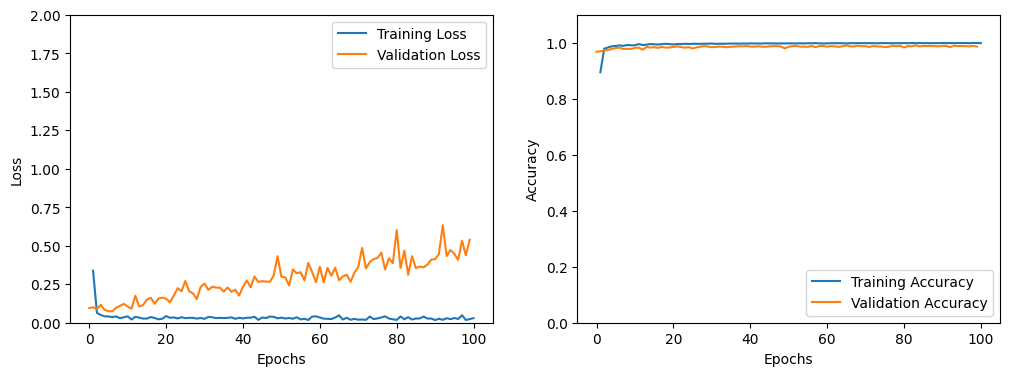

In [18]:
history = pd.read_excel('/kaggle/working/training_data.xlsx')

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['Epoch'], history['Train Loss'], label='Train Loss')
plt.plot(history['Validation Loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.ylim(0,2)

plt.subplot(1, 2, 2)
plt.plot(history['Epoch'], history['Train Accuracy'], label='Train Accuracy')
plt.plot(history['Validation Accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.ylim(0,1.1)

plt.show()

# EVOLUTION

In [19]:
def evaluate_model(model, criterion, dataloader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = running_loss / total
    accuracy = correct / total

    return loss, accuracy

In [20]:
best_checkpoint_path = f"{save_path_checkpoints}/model.pt"
checkpoint = torch.load(best_checkpoint_path)
best_epoch = checkpoint["epoch"]
model.load_state_dict(checkpoint["model_weight"])
optimizer.load_state_dict(checkpoint["optimizer_state"])

best_val_loss, best_val_accuracy = evaluate_model(model, criterion, dataloader_valid_dataset)
print(f"Best model (from epoch {best_epoch}) - Validation Loss: {best_val_loss:.3f}, Validation Accuracy: {best_val_accuracy:.5f}")

Best model (from epoch 66) - Validation Loss: 0.276, Validation Accuracy: 0.99053


In [21]:
start_time = time.time()

test_loss, test_accuracy = evaluate_model(model, criterion, dataloader_test_dataset)
print(f"Test Accuracy: {test_accuracy:.3f}")

end_time = time.time()
test_time = end_time - start_time
print(f"Test Time: {test_time:.2f} seconds ---> {test_time/60:.2f} minutes")

Test Accuracy: 0.986
Test Time: 35.85 seconds ---> 0.60 minutes


In [22]:
def class_accuracy(model, dataloader, num_classes):
    class_correct = [0.0] * num_classes
    class_total = [0.0] * num_classes

    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels)
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

    class_accuracy = [class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)]

    return class_accuracy

y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for inputs, labels in dataloader_test_dataset:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

class_names = [str(i) for i in range(total_class)]

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

class_acc = class_accuracy(model, dataloader_test_dataset, total_class)
for i in range(total_class):
    print(f"Class {i} Accuracy: {class_acc[i]:.3f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       375
           1       0.96      0.98      0.97       375
           2       0.99      1.00      0.99       375
           3       0.99      1.00      0.99       375
           4       0.99      0.99      0.99       375
           5       0.99      0.99      0.99       375
           6       0.97      0.99      0.98       375
           7       0.99      0.98      0.98       375
           8       1.00      1.00      1.00       375
           9       0.99      1.00      1.00       375
          10       0.99      0.98      0.99       375
          11       0.99      0.98      0.99       375
          12       0.99      0.99      0.99       375
          13       1.00      0.99      0.99       375
          14       0.99      0.95      0.97       375
          15       0.96      0.99      0.98       375
          16       0.98      0.95      0.97       375
    